# Portfolio construction model example 2 (Trader Joe)

This is an example notebook how to construct a momentum based portfolio construction strategy
using [Trading Strategy framework](https://tradingstrategy.ai/docs/) and backtest it for DeFi tokens.

This backtest uses alpha model approach where each trading pair has a signal
and basede on the signal strenghts we construct new portfolio weightings 
for the upcoming week.

Some highlights of this notebook:

* **Not a realistic trading strategy, but more of an code example** - this may generate profits or loss but this is outside the scode of this example
* Make sure you have studied some simpler backtesting examples first
* The backtest has all its code within a single Jupyter notebook
    - The backtest code and charts are self-contained in a single file
    - The example code is easy to read
* Runs a backtest for a momentum strategy
    - Long only    
    - Because the strategy is long only, it trades only in a bull market, defined by a moving average signal
    - Automatically chooses tokens that enter and exit market at Trader Joe DEX on Avalanche
    - Support pairs that trade against AVAX and USDC (quote tokens)
    - Check trading pair available liquidity before taking any positions - uses coarse (resampled) liquidity data for liquidity aware backtesting    
    - Pick some top tokens for each strategy cycle
    - Based on using a trading pair momentum as an alpha signal
    - Uses take profit / stop loss to close the positions outside the rebalance cycle
    - Ignores price impact, and thus may cause unrealistic results
    - Ignores extra fees on a three leg trade of USDC->AVAX->target asset when opening a position
* Demostrates statistics and performance analyses
    - Equity curve with comparison to buy and hold AVAX
    - Bull/bear market indicator when the strategy is trading
    - Summary statistics of the strategy
    - Summary statistics of individual pairs traded
* You need a [Trading Strategy API key](https://tradingstrategy.ai/trading-view/backtesting) to run the notebook
* The notebook will download more than 10GB data
* You will need a powerful computer to run this notebook (> 16GB RAM)



## Strategy parameter set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Different lookback and technical indicator periods
- Take profit and stop loss thresholds
- Minimu liquidity thresholds
- Upwards momentum thresholds

In [1]:
import datetime
import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import StrategyType, TradeRouting, ReserveCurrency

# Tell what trade execution engine version this strategy needs to use
trading_strategy_engine_version = "0.1"

# What kind of strategy we are running.
# This tells we are going to use
trading_strategy_type = StrategyType.managed_positions

# How our trades are routed.
# PancakeSwap basic routing supports two way trades with BUSD
# and three way trades with BUSD-BNB hop.
trade_routing = TradeRouting.ignore

# Set cycle to 7 days and look back the momentum of the previous candle
trading_strategy_cycle = CycleDuration.cycle_4d
momentum_lookback_period = datetime.timedelta(days=4)

# Hold N top coins for every cycle
max_assets_in_portfolio = 3

# Leave 20% cash buffer
value_allocated_to_positions = 0.50

#
# Set the take profit/stop loss for our postions.
# Aim for asymmetric opportunities - upside is higher than downside
#

# Set % stop loss over mid price
stop_loss = 0.95

# Set % take profit over mid price
take_profit = 1.33

# The momentum period price must be up % for us to take a long position
#minimum_mometum_threshold = 0.025
minimum_mometum_threshold = 0.015

# The amount of XY liquidity a pair must have on Trader Joe before 
# we are happy to take any position.
minimum_liquidity_threshold = 100_000

# Don't bother with trades that would move position
# less than 300 USD
minimum_rebalance_trade_threshold = 300

# decide_trades() operates on 1d candles
candle_data_time_frame = TimeBucket.d1

# Use hourly candles to trigger the stop loss
stop_loss_data_granularity = TimeBucket.h1

# Strategy keeps its cash in USDC
reserve_currency = ReserveCurrency.usdc

# Define the periods when the native asset price is
# above its simple moving average (SMA)
bull_market_moving_average_window = pd.Timedelta(days=20)

# The duration of the backtesting period
start_at = datetime.datetime(2021, 12, 1)
end_at = datetime.datetime(2023, 2, 20)

# Start with 10,000 USD
initial_deposit = 10_000


## Strategy logic and trade decisions

`decide_trades` function decide what trades to take.
In this example, we calculate two exponential moving averages
(EMAs) and make decisions based on those.


In [2]:
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.strategy.trading_strategy_universe import translate_trading_pair
from typing import List, Dict

from pandas_ta.overlap import sma

from tradingstrategy.universe import Universe
from tradeexecutor.strategy.weighting import weight_by_1_slash_n
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State


def decide_trades(
        timestamp: pd.Timestamp,
        universe: Universe,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)

    alpha_model = AlphaModel(timestamp)

    # Watch out for the inclusive range and include and avoid peeking in the future
    adjusted_timestamp = timestamp - pd.Timedelta(seconds=1)
    start = adjusted_timestamp - momentum_lookback_period - datetime.timedelta(seconds=1)
    end = adjusted_timestamp 

    candle_universe = universe.candles
    pair_universe = universe.pairs

    # First figure out are we in a bear or a bull market condition.
    # Our rule for a bull market is that the price of the native token of the blockchain
    # is above its simple moving average.
    # Please see the notebook commments why we define this condition like this.
    bullish = False

    # Plot the AVAX simple moving average.
    avax = pair_universe.get_pair(
        ChainId.avalanche,
        "trader-joe",
        "WAVAX",
        "USDC"
    )

    avax_candles = candle_universe.get_last_entries_by_pair_and_timestamp(avax.pair_id, timestamp)

    if len(avax_candles) > 0:
        avax_close = avax_candles["close"]
        avax_price_now = avax_close.iloc[-1]

        # Count how many candles worth of data needed
        avax_sma = sma(avax_close, length=bull_market_moving_average_window / candle_data_time_frame.to_timedelta())
        if avax_sma is not None:
            # SMA cannot be forward filled at the beginning of the backtest period
            sma_now = avax_sma[-1]
            assert sma_now > 0, f"SMA was zero for {timestamp}, probably issue with the data?"
            state.visualisation.plot_indicator(
                timestamp,
                "Native token SMA",
                PlotKind.technical_indicator_on_price,
                sma_now,
            )

            if avax_price_now > sma_now:
                bullish = True

        # Get candle data for all candles, inclusive time range
    candle_data = candle_universe.iterate_samples_by_pair_range(start, end)

    # Because this is long only strategy, we will honour our momentum signals only in a bull market
    if bullish:

        # Iterate over all candles for all pairs in this timestamp (ts)
        for pair_id, pair_df in candle_data:

            last_candle = pair_df.iloc[-1]

            assert last_candle["timestamp"] < timestamp, "Something wrong with the data - we should not be able to peek the candle of the current timestamp, but always use the previous candle"

            open = last_candle["open"]
            close = last_candle["close"]

            # Get the pair information and translate it to a serialisable strategy object
            dex_pair = pair_universe.get_pair_by_id(pair_id)
            pair = translate_trading_pair(dex_pair)

            available_liquidity = universe.resampled_liquidity.get_liquidity_fast(pair_id, adjusted_timestamp)
            if available_liquidity < minimum_liquidity_threshold:
                # Too limited liquidity, skip this pair
                continue

            # We define momentum as how many % the trading pair price gained during
            # the momentum window
            momentum = (close - open) / open

            # This pair has not positive momentum,
            # we only buy when stuff goes up
            if momentum <= minimum_mometum_threshold:
                continue

            alpha_model.set_signal(
                pair,
                momentum,
                stop_loss=stop_loss,
                take_profit=take_profit,
            )

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_by_1_slash_n)
    alpha_model.normalise_weights()

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(state.portfolio)

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * value_allocated_to_positions
    alpha_model.calculate_target_positions(position_manager, portfolio_target_value)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=minimum_rebalance_trade_threshold,  # Don't bother with trades under 300 USD
    )

    # Record alpha model state so we can later visualise our alpha model thinking better
    state.visualisation.add_calculations(timestamp, alpha_model.to_dict())

    return trades


## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [3]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/alex/.tradingstrategy


## Setup trading universe

We setup the trading universe for the backtesting.

- Read in a handwritten allowed trading pair universe list

- Download candle data

- Print out trading pair addresses and volumes as the sanity check the pair defintions look correct

- Normal, it is more efficient to use `load_partial_data` instead of all `load_all_data`, but in this particular example, we include logic to check all pairs in the universe instead of a list of predefined pairs, so we need to use `load_all_data`


In [4]:
from tradingstrategy.client import Client

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_all_data
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.ethereum.routing_data import get_trader_joe_default_routing_parameters


def create_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:

    assert not execution_context.mode.is_live_trading(), \
        f"Only strategy backtesting supported, got {execution_context.mode}"

    # Load data for our trading pair whitelist
    dataset = load_all_data(
        client,
        execution_context=execution_context,
        time_frame=candle_data_time_frame,
        universe_options=universe_options,
        liquidity_time_frame=TimeBucket.d1,
        stop_loss_time_frame=stop_loss_data_granularity,
    )

    routing_parameters = get_trader_joe_default_routing_parameters(reserve_currency)

    quote_tokens = {
        "0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e",  # USDC
        "0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7",  # WAVAX
    }

    universe = TradingStrategyUniverse.create_multipair_universe(
        dataset,
        [ChainId.avalanche],
        ["trader-joe"],
        quote_tokens=quote_tokens,
        reserve_token=routing_parameters["reserve_token_address"],
        factory_router_map=routing_parameters["factory_router_map"],
        liquidity_resample_frequency="1D",
    )

    return universe

universe = create_trading_universe(
    datetime.datetime.utcnow(),
    client,
    ExecutionContext(mode=ExecutionMode.backtesting),
    UniverseOptions(),
)

print(f"The trading univers has {universe.get_pair_count()} trading pairs")

Resamping liquidity data to 1D, this may take a long time
The trading univers has 1351 trading pairs


## Run backtest

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.
- The trade execution engine will download the necessary datasets to run the backtest.
  The datasets may be large, several gigabytes.


In [5]:
import logging

from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="Example strategy",
    start_at=start_at,
    end_at=end_at,
    client=client,
    cycle_duration=trading_strategy_cycle,
    decide_trades=decide_trades,
    create_trading_universe=create_trading_universe,
    initial_deposit=initial_deposit,
    reserve_currency=reserve_currency,
    trade_routing=trade_routing,
    log_level=logging.WARNING,
    universe=universe,
    data_delay_tolerance=pd.Timedelta("7d"),
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/38534400 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 195 trades


## Examine backtest results

Examine `state` that contains 
- All actions the trade executor took
- Visualisation and diagnostics data associated with the actity

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [6]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 95
Trades made: 195


## Benchmarking the strategy performance

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold AVAX
- Buy and hold US Dollar (do nothing)


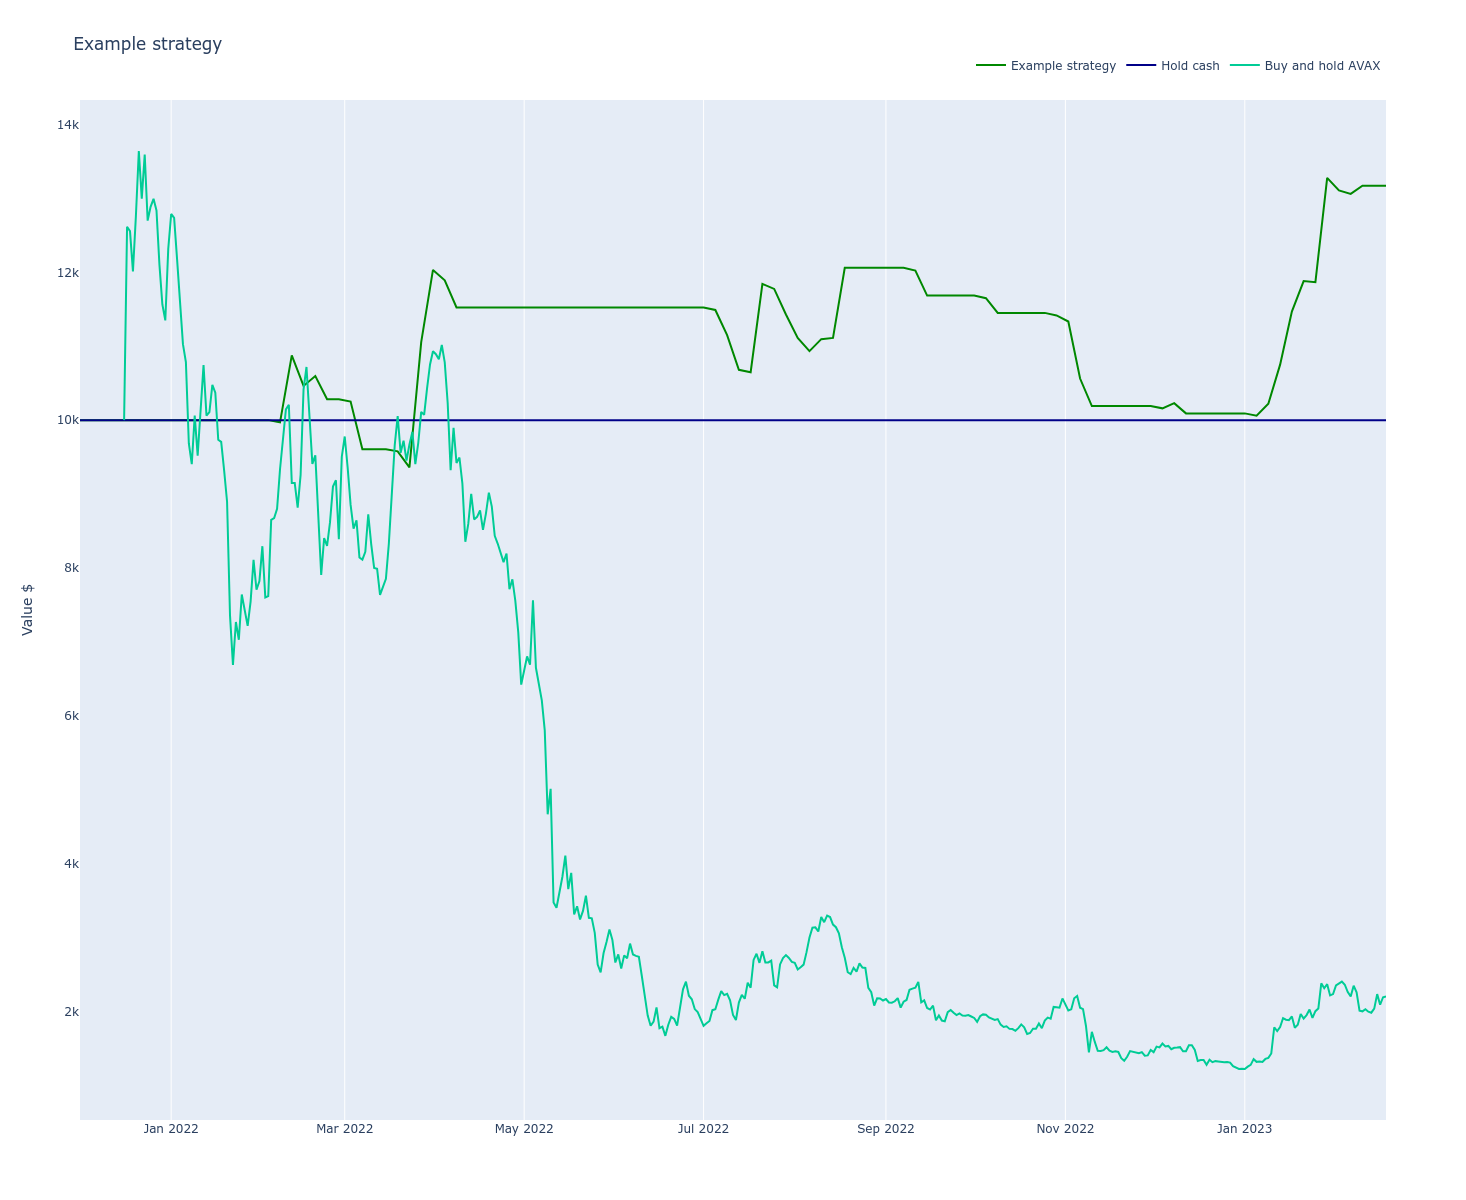

In [7]:
from tradeexecutor.visual.benchmark import visualise_benchmark

avax_usd = universe.get_pair_by_human_description((ChainId.avalanche, "trader-joe", "WAVAX", "USDC"))
avax_candles = universe.universe.candles.get_candles_by_pair(avax_usd.internal_id)

fig = visualise_benchmark(
    state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name="AVAX",
    buy_and_hold_price_series=avax_candles["close"],
    start_at=start_at,
    end_at=end_at
)

fig.show()

## Bull/bear market moving average analysis

Most Trader Joe pairs trade against AVAX, not USDC. Thus, prices are tightly correlated with AVAX price drops. 
We do not want to trade using a long only strategy in a "bear market" when all assets are dropping, 
as slow moving momentum strategy won't be able to catch good pumps.



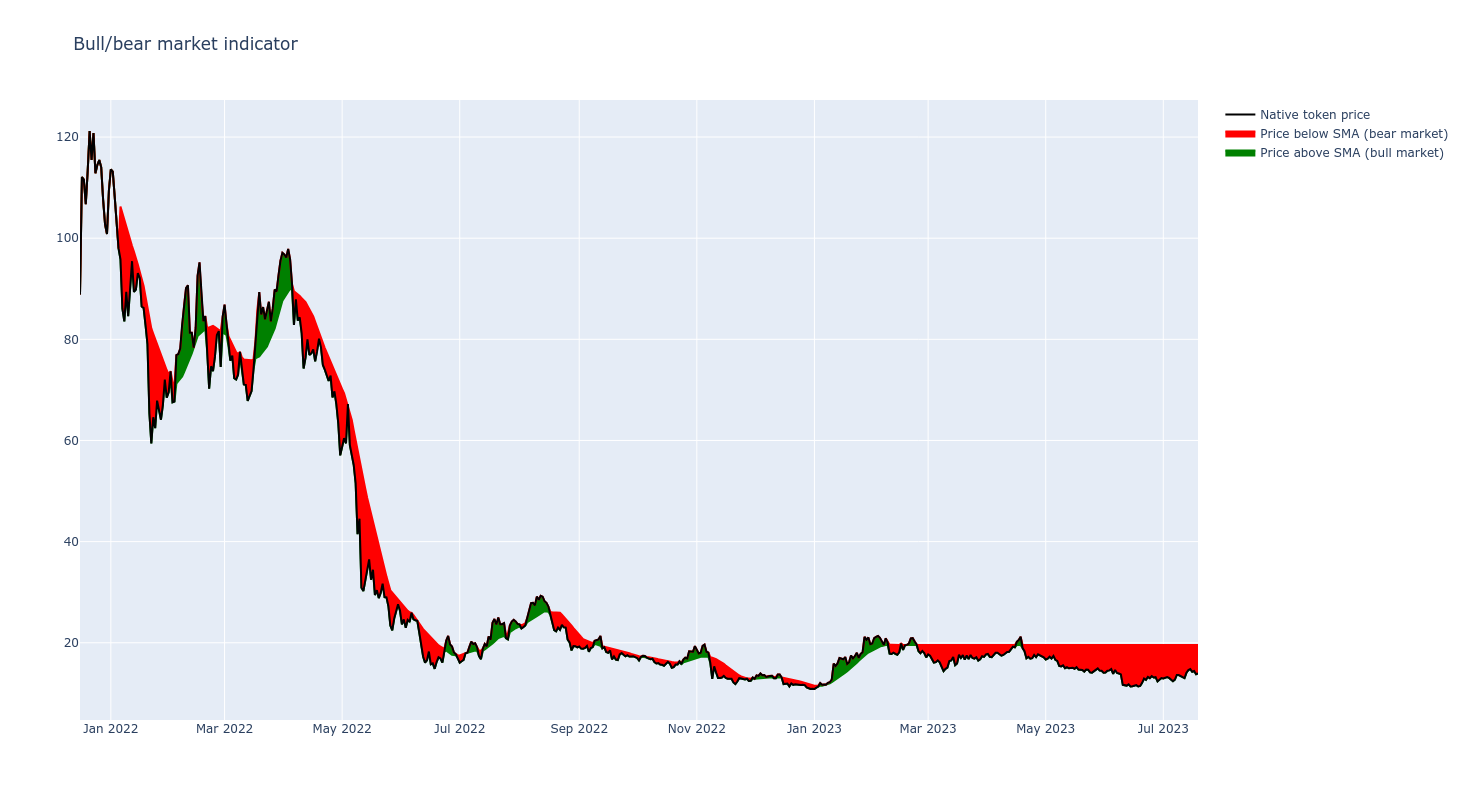

In [8]:
import plotly.graph_objects as go
from tradeexecutor.visual.technical_indicator import export_plot_as_dataframe

# Set up DataFrames where one has price and one has moving average
candles = avax_candles  # OHLCV data
sma_plot = state.visualisation.plots["Native token SMA"]
sma_df = export_plot_as_dataframe(sma_plot)  # Simple moving average values

# Create a DataFrame that contains values from all of our plots using the same master DateTimeIndex.
# Namely moving averages have less samples, because moving average cannot be calculated
# early on as the time window has not yet enough data.
# We will also interpolate indicator values, as our indicator has less granular
# DateTimeIndex as the price data.
indicator_df = pd.DataFrame(index=candles.index)
indicator_df["price"] = candles["close"]
indicator_df["indicator_value"] = sma_df["value"]
indicator_df["indicator_value"].interpolate(inplace=True)

# There is a multiyear bug in Plotly that you cannot use connectgaps and fill in the same plot.
# This is why we set the indicator value to the price value when we do not want to plot the area,
# as this will fill area with the size of 0
# https://github.com/plotly/plotly.js/issues/1132#issuecomment-531030346
indicator_df["green_above"] = indicator_df.apply(lambda row: row["indicator_value"] if row["price"] > row["indicator_value"] else row["price"], axis="columns")
indicator_df["red_below"] = indicator_df.apply(lambda row: row["indicator_value"] if row["price"] <= row["indicator_value"] else row["price"], axis="columns")

# Fill the area between close price and SMA indicator
# See https://plotly.com/python/filled-area-plots/#interior-filling-for-area-chart
# See also https://stackoverflow.com/a/64743166/315168
fig = go.Figure(
    layout={
        "title": "Bull/bear market indicator",
        "height": 800,
    }
)

# We need to use an invisible trace so we can reset "next y"
# for the red area indicator
fig.add_trace(
    go.Scatter(
        x=indicator_df.index,
        y=indicator_df["price"],
        line_color="rgba(0,0,0,0)",
        showlegend=False,
    )
)

# Plot out the
fig.add_trace(
    go.Scatter(
        x=indicator_df.index,
        y=indicator_df["green_above"],
        name="Price above SMA (bull market)",
        line_color="green",
        connectgaps=False,
        fillcolor="green",
        fill='tonexty',
    )
)

# We need to use an invisible trace so we can reset "next y"
fig.add_trace(
    go.Scatter(
        x=indicator_df.index,
        y=indicator_df["price"],
        line_color="rgba(0,0,0,0)",
        showlegend=False,
    )
)

fig.add_trace(
    go.Scatter(
        x=indicator_df.index,
        y=indicator_df["red_below"],
        name="Price below SMA (bear market)",
        line_color="red",
        connectgaps=False,
        fillcolor="red",
        fill='tonexty',
    )
)

fig.add_trace(
    go.Scatter(
        x=indicator_df.index,
        y=indicator_df["price"],
        name=f"Native token price",
        line_color="black",
    )
)

display(fig)

## Analysing the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [9]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Strategy summary

Overview of strategy performance



In [10]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

0
Trading period length                   368 days 0 hours
Return %                                          31.70%
Annualised return %                               31.44%
Cash at start                                 $10,000.00
Value at end                                  $13,170.28
Trade volume                                 $375,416.22
Position win percent                              32.63%
Total positions                                       95
Won positions                                         31
Lost positions                                        64
Stop losses triggered                                 48
Stop loss % of all                                50.53%
Stop loss % of lost                               75.00%
Winning stop losses                                    0
Winning stop losses percent                        0.00%
Losing stop losses                                    48
Losing stop losses percent                       100.00%
Take profits triggered                                 9
Take profit % of all                               9.47%
Take profit % of won                              29.03%
Zero profit positions                                  0
Positions open at the end                              0
Realised profit and loss                       $3,170.28
Portfolio unrealised value                         $0.00
Extra returns on lending pool interest             $0.00
Cash left at the end                          $13,170.28
Average winning position profit %                 16.20%
Average losing position loss %                    -6.48%
Biggest winning position %                        62.50%
Biggest losing position %                        -37.07%
Average duration of winning positions    4 days 11 hours
Average duration of losing positions      2 days 1 hours
LP fees paid                                   $1,127.96
LP fees paid % of volume                           0.30%
Average position:                                  0.92%
Median position:                                  -5.58%
Most consecutive wins                                  5
Most consecutive losses                                9
Biggest realized risk                             -5.22%
Avg realised risk                                 -1.09%
Max pullback of total capital                    -13.00%
Max loss risk at opening of position               2.64%

## Trading pair analysis

Show the summary of the strategy trades for each different trading pair.


In [11]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
display(format_multipair_summary(multipair_summary))

## Alpha model timeline

**We do not display individual timeline of the positions due to large number of pairs involved**.



## Individual pair analysis

Examine one trading pair and how it performed.



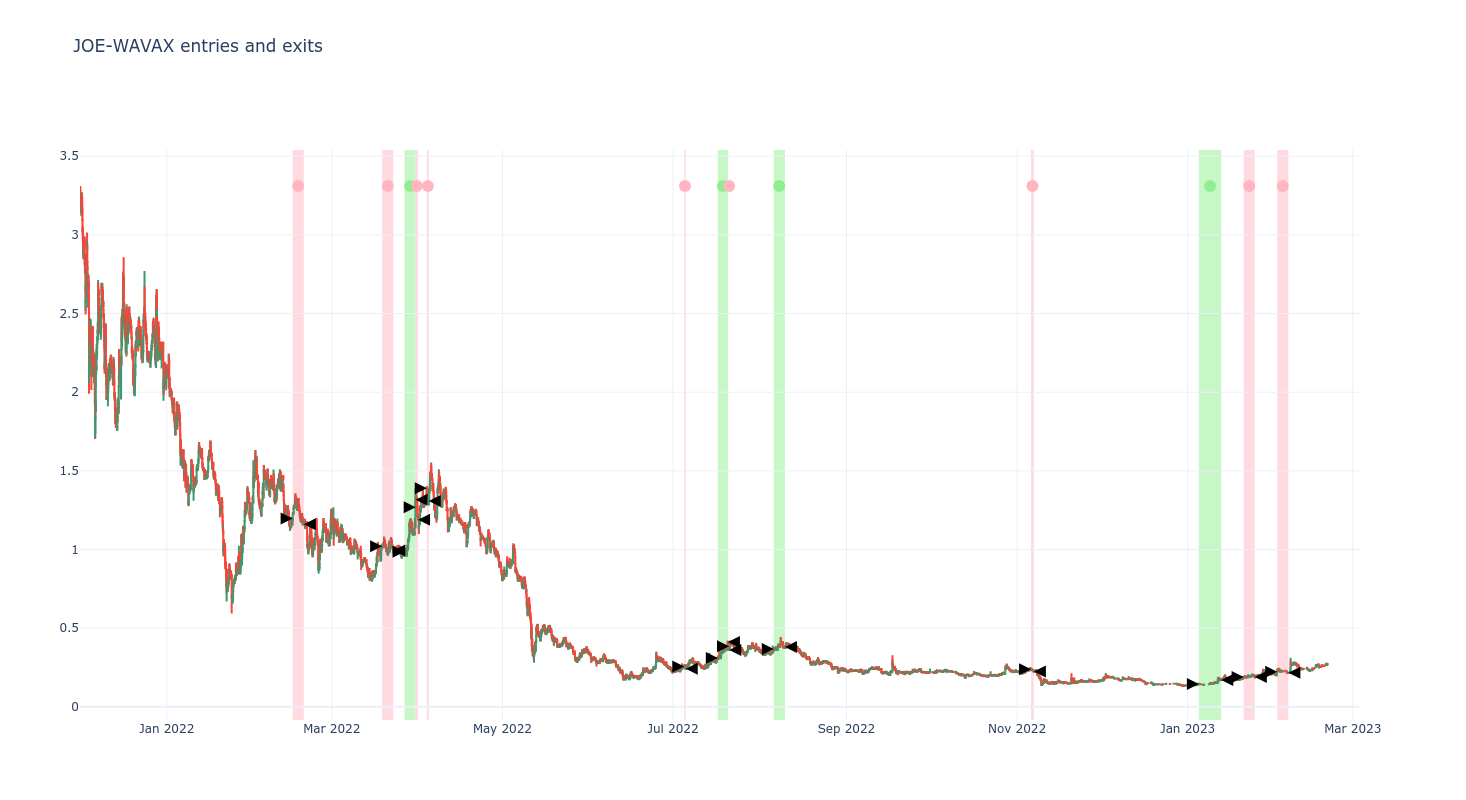

In [12]:
from tradeexecutor.visual.single_pair import visualise_single_pair_positions_with_duration_and_slippage

target_pair = universe.universe.pairs.get_pair(
    ChainId.avalanche,
    "trader-joe",
    "JOE",
    "WAVAX"
)

ticker = target_pair.get_ticker()
pair_candles = universe.backtest_stop_loss_candles.get_candles_by_pair(target_pair.pair_id)

fig = visualise_single_pair_positions_with_duration_and_slippage(
    state,
    pair_id=target_pair.pair_id,
    title=f"{ticker} entries and exits",
    candles=pair_candles,
    start_at=start_at,
    end_at=end_at,
    technical_indicators=False,
)

fig.show()

## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [13]:
print("All ok")

All ok
